# Import

In [1]:
%load_ext autoreload
%autoreload 2
from torch.utils.data import DataLoader
import torch
import pytorch_lightning as pl
from pathlib import Path
import os
import time
import datetime
import yaml
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)

import logging

from tqdm.notebook import tqdm

import volpick.model.models as models
import seisbench.models as sbm
import seisbench.generate as sbg
from volpick.model.utils import load_best_model_from_base_dir,load_best_model,plot_prediction_examples
import seisbench.data as sbd
from volpick.model.generate_eval_targets import generate_task0, generate_task1, generate_task23

from obspy.signal.trigger import recursive_sta_lta, trigger_onset
from volpick.model.models import phase_dict
from volpick.model.eval_taks0 import evaluate, get_ground_truth, count_TP_FP_FN, compute_residuals, calculate_precision_recall_F1score, eval_task0, opt_prob_metrics, collect_task0_results,collect_task0_results_dev
from volpick.model.eval_taks123 import eval_tasks123,collect_task123_results

import json

from sklearn.metrics import roc_curve, precision_recall_curve, roc_auc_score

In [2]:
def lteq(a, b):
    """return a<=b"""
    return (a < b) | (abs(a - b) < 1e-12)  # parentheses are important!!!


print(lteq(10, 20))
print(lteq(np.array([10.0, 20.0]), 20.0))

True
[ True  True]


# Load data

In [3]:
data_path = Path("/home/zhongyiyuan/DATA/my_datasets_seisbench/vcseis")

dataset = sbd.WaveformDataset(
    data_path,
    sampling_rate=100,
    component_order="ZNE",
    dimension_order="NCW",
    cache="full",
)
dataset.filter(dataset["split"].isin(["test"]), inplace=True)
dataset.preload_waveforms(pbar=True)

# print(len(dataset))

Preloading waveforms: 100%|██████████| 35120/35120 [00:05<00:00, 6709.42it/s] 


In [4]:
data_eq = dataset.filter(dataset["source_type"] != "noise", inplace=False).test()
np.all((data_eq["split"] == "test").values)

True

In [5]:
data_path = Path("/home/zhongyiyuan/DATA/my_datasets_seisbench/vcseis")

dataset_ENZ = sbd.WaveformDataset(
    data_path,
    sampling_rate=100,
    component_order="ENZ",
    dimension_order="NCW",
    cache="full",
)
dataset_ENZ.filter(dataset_ENZ["split"].isin(["test"]), inplace=True)
dataset_ENZ.preload_waveforms(pbar=True)

Preloading waveforms: 100%|██████████| 35120/35120 [00:05<00:00, 6734.99it/s] 


In [6]:
data_eq_ENZ = dataset_ENZ.filter(
    dataset_ENZ["source_type"] != "noise", inplace=False
).test()
np.all((data_eq_ENZ["split"] == "test").values)

True

# Load models

In [7]:
vol_eqt = sbm.EQTransformer.from_pretrained("volpick")
vol_eqt.cuda()
vol_pn = sbm.PhaseNet.from_pretrained("volpick")
vol_pn.cuda()
print(vol_eqt.labels)
print(vol_pn.labels)
print(vol_eqt.norm)
print(vol_pn.norm)
print(vol_eqt.device)
print(vol_pn.device)

['Detection', 'P', 'S']
PSN
peak
peak
cuda:0
cuda:0


In [43]:
test_model = sbm.GPD.from_pretrained(
    "original",
    version_str="1",
)

In [8]:
org_eqt = sbm.EQTransformer.from_pretrained("original")
org_eqt2 = sbm.EQTransformer.from_pretrained("original_nonconservative")
org_pn = sbm.PhaseNet.from_pretrained("original")
org_eqt.cuda()
org_eqt2.cuda()
org_pn.cuda()
print(org_eqt.labels)
print(org_eqt2.labels)
print(org_pn.labels)
print(org_eqt.norm)
print(org_eqt2.norm)
print(org_pn.norm)
print(org_eqt.device)
print(org_eqt2.device)
print(org_pn.device)

eqt_instance = sbm.EQTransformer.from_pretrained("instance")
pn_instance = sbm.PhaseNet.from_pretrained("instance")
eqt_instance.cuda()
pn_instance.cuda()
print(eqt_instance.labels)
print(pn_instance.labels)
print(eqt_instance.norm)
print(pn_instance.norm)
print(eqt_instance.device)
print(pn_instance.device)

['Detection', 'P', 'S']
['Detection', 'P', 'S']
NPS
std
std
std
cuda:0
cuda:0
cuda:0
['Detection', 'P', 'S']
PSN
peak
peak
cuda:0
cuda:0


# Figure saving path

In [3]:
root_save_path = Path("./")
try:
    root_save_path.mkdir(parents=True, exist_ok=False)
except FileExistsError:
    print(f"{root_save_path} exists")

. exists


# Frequency index

In [10]:
freq_indices = data_eq.metadata.drop_duplicates(
    subset="source_id", keep="first", inplace=False
)["source_frequency_index"].to_numpy()
source_ids = data_eq.metadata.drop_duplicates(
    subset="source_id", keep="first", inplace=False
)["source_id"].to_numpy()

# lp and vt
lp_metadata = data_eq.metadata[data_eq.metadata["source_type"] == "lp"]
rg_metadata = data_eq.metadata[data_eq.metadata["source_type"] != "lp"]
print(len(lp_metadata))
print(len(rg_metadata))

# frequency indexes of lp events and vt events
freq_indices_lp = lp_metadata.drop_duplicates(
    subset="source_id", keep="first", inplace=False
)["source_frequency_index"].to_numpy()
freq_indices_rg = rg_metadata.drop_duplicates(
    subset="source_id", keep="first", inplace=False
)["source_frequency_index"].to_numpy()

15078
15057


In [11]:
# frequency index for each trace
trace_freq_indices = data_eq.metadata["trace_frequency_index"]
trace_freq_indices_lp = lp_metadata["trace_frequency_index"]
trace_freq_indices_rg = rg_metadata["trace_frequency_index"]

In [12]:
print(f"Total {len(freq_indices)}")
print(f"LP: {len(freq_indices_lp)}")
print(f"VT: {len(freq_indices_rg)}")

# validate
print(len(freq_indices_rg) + len(freq_indices_lp) == len(freq_indices))
print(
    np.all(
        np.sort(np.concatenate((freq_indices_rg, freq_indices_lp)))
        == np.sort(freq_indices)
    )
)
# print(np.sum(np.sort(np.concatenate((freq_indices_rg, freq_indices_lp)))-np.sort(freq_indices)))

print(
    len(trace_freq_indices_rg) + len(trace_freq_indices_lp) == len(trace_freq_indices)
)
print(
    np.all(
        np.sort(np.concatenate((trace_freq_indices_rg, trace_freq_indices_lp)))
        == np.sort(trace_freq_indices)
    )
)
# print(np.sum(np.sort(np.concatenate((trace_freq_indices_rg, trace_freq_indices_lp)))-np.sort(trace_freq_indices)))

Total 23700
LP: 11798
VT: 11902
True
True
True
True


max 1.7097844144183325
min -2.678715296267784
max 1.0597718278203687
min -2.343523628440629


Text(0, 0.5, 'Count')

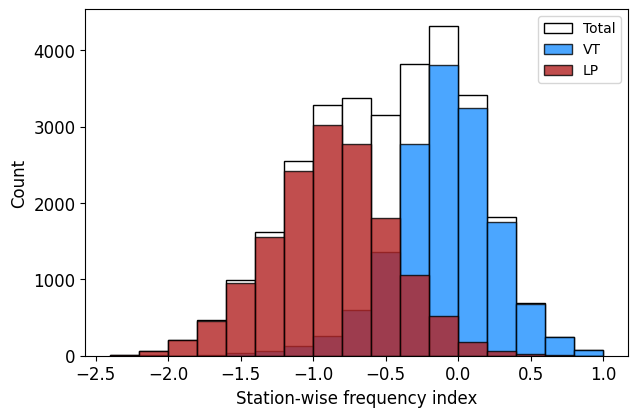

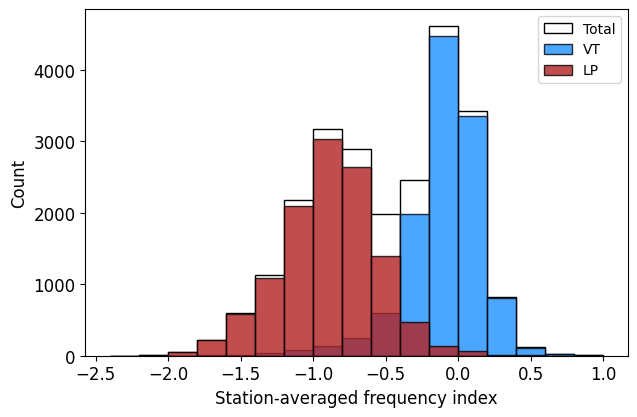

In [13]:
print(f"max {np.max(trace_freq_indices)}")
print(f"min {np.min(trace_freq_indices)}")
fts = 12
fig = plt.figure(figsize=(7, 4.5))

bins = np.arange(-2.4, 1.2, 0.2)
plt.hist(
    trace_freq_indices,
    bins,
    density=False,
    stacked=True,
    color="white",
    edgecolor="black",
    label="Total",
)
plt.hist(
    trace_freq_indices_rg,
    bins,
    density=False,
    edgecolor="black",
    color="dodgerblue",
    alpha=0.8,
    label="VT",
)
plt.hist(
    trace_freq_indices_lp,
    bins,
    density=False,
    edgecolor="black",
    color="firebrick",
    alpha=0.8,
    label="LP",
)
plt.gca().tick_params(labelsize=fts)
plt.legend()
plt.xlabel("Station-wise frequency index", fontsize=fts)
plt.ylabel("Count", fontsize=fts)
# plt.savefig(root_save_path / "FI_by_traces.jpg", bbox_inches="tight", dpi=600)
# plt.savefig(root_save_path/"FI_by_traces.pdf", bbox_inches="tight", dpi=600)

print(f"max {np.max(freq_indices)}")
print(f"min {np.min(freq_indices)}")
fts = 12
fig = plt.figure(figsize=(7, 4.5))


plt.hist(
    freq_indices, bins, density=False, color="white", edgecolor="black", label="Total"
)
plt.hist(
    freq_indices_rg,
    bins,
    density=False,
    color="dodgerblue",
    edgecolor="black",
    alpha=0.8,
    label="VT",
)
plt.hist(
    freq_indices_lp,
    bins,
    density=False,
    color="firebrick",
    edgecolor="black",
    alpha=0.8,
    label="LP",
)

plt.gca().tick_params(labelsize=fts)
plt.legend()
plt.xlabel("Station-averaged frequency index", fontsize=fts)
plt.ylabel("Count", fontsize=fts)
# plt.savefig(
#     root_save_path / "FI_averaged_over_stations.jpg", bbox_inches="tight", dpi=600
# )

# Evaluation

In [13]:
bins = np.arange(-2.4, 1.2, 0.2)
for x, y in zip(bins[:-1], bins[1:]):
    print(f"{x:15e}, {y:15e}")

  -2.400000e+00,   -2.200000e+00
  -2.200000e+00,   -2.000000e+00
  -2.000000e+00,   -1.800000e+00
  -1.800000e+00,   -1.600000e+00
  -1.600000e+00,   -1.400000e+00
  -1.400000e+00,   -1.200000e+00
  -1.200000e+00,   -1.000000e+00
  -1.000000e+00,   -8.000000e-01
  -8.000000e-01,   -6.000000e-01
  -6.000000e-01,   -4.000000e-01
  -4.000000e-01,   -2.000000e-01
  -2.000000e-01,    2.220446e-15
   2.220446e-15,    2.000000e-01
   2.000000e-01,    4.000000e-01
   4.000000e-01,    6.000000e-01
   6.000000e-01,    8.000000e-01
   8.000000e-01,    1.000000e+00


(array([408., 355., 323., 362., 358., 332., 317., 326., 337., 268., 288.,
        223., 267., 259., 227., 224., 221., 265., 205., 218., 218., 197.,
        182., 236., 223., 220., 274., 228., 321., 310., 286., 316., 362.,
        416., 428., 441., 497., 516., 535., 502., 607., 616., 607., 590.,
        613., 558., 500., 501., 416., 412.]),
 array([-0.79999948, -0.78200138, -0.76400327, -0.74600517, -0.72800707,
        -0.71000896, -0.69201086, -0.67401276, -0.65601465, -0.63801655,
        -0.62001845, -0.60202034, -0.58402224, -0.56602413, -0.54802603,
        -0.53002793, -0.51202982, -0.49403172, -0.47603362, -0.45803551,
        -0.44003741, -0.42203931, -0.4040412 , -0.3860431 , -0.368045  ,
        -0.35004689, -0.33204879, -0.31405069, -0.29605258, -0.27805448,
        -0.26005638, -0.24205827, -0.22406017, -0.20606206, -0.18806396,
        -0.17006586, -0.15206775, -0.13406965, -0.11607155, -0.09807344,
        -0.08007534, -0.06207724, -0.04407913, -0.02608103, -0.00808293,
 

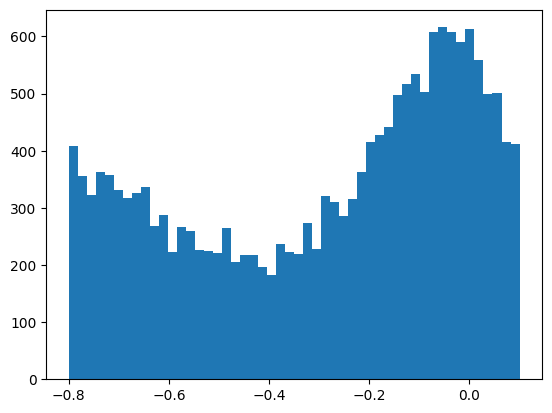

In [14]:
plt.hist(
    data_eq.metadata[
        (data_eq.metadata["source_frequency_index"] > -0.8)
        & (lteq(data_eq.metadata["source_frequency_index"], 0.1))
    ]["source_frequency_index"],
    50,
)

In [15]:
data_eq["trace_name"]

8            bucket8$0,:3,:12192
12           bucket8$1,:3,:12099
16           bucket8$2,:3,:12263
37           bucket8$3,:3,:12257
43           bucket8$4,:3,:12250
                   ...          
315440     bucket81$382,:3,:8900
315458     bucket81$383,:3,:8958
315467    bucket89$758,:3,:11700
315477     bucket81$384,:3,:9499
315485    bucket89$759,:3,:11600
Name: trace_name, Length: 30135, dtype: object

## Predict

In [16]:
tp_thre = 0.5
print(bins)
t1 = time.perf_counter()
FIstrings = []
FIs_midpoint = []
num_seis = {}
for x, y in zip(bins[:-1], bins[1:]):
    mask = (data_eq.metadata["source_frequency_index"] > x) & (
        lteq(data_eq.metadata["source_frequency_index"], y)
    )

    sub_dataset = data_eq.filter(mask, inplace=False)

    mask2 = (data_eq_ENZ.metadata["source_frequency_index"] > x) & (
        lteq(data_eq_ENZ.metadata["source_frequency_index"], y)
    )
    sub_dataset_ENZ = data_eq_ENZ.filter(mask2, inplace=False)
    if len(sub_dataset) > 0:
        fi_str = f"({x:.1f},{y:.1f}]"
        # FI_dataset_map[f"{0.5*(x+y):.2f}"]=sub_dataset
        FIstrings.append(fi_str)
        FIs_midpoint.append(0.5 * (x + y))
        print(fi_str, len(sub_dataset))
        num_seis[fi_str] = len(sub_dataset)

        # sub_dataset._metadata["split"]="test"

        targets_path_fi = root_save_path / f"{fi_str}"
        try:
            targets_path_fi.mkdir(parents=True, exist_ok=False)
        except FileExistsError:
            print(f"{targets_path_fi} exists")
        generate_task0(
            dataset=sub_dataset,
            output=targets_path_fi,
            sampling_rate=100,
            noise_before_events=False,
            replace_if_exist=True,
        )

        # for model in original_model_list:
        #     eval_task0(dev_test_set=sub_dataset,
        #                 model=model,
        #                 exp_name=f"{model.name}_original",
        #                 targets_path=targets_path_fi,
        #                 prob_thres=np.array([0.2, 0.225, 0.25,0.275, 0.3,0.35, 0.4, 0.5]),
        #                 num_workers=16,
        #                 batchsize=2048,
        #                 num_test_run=-1,
        #                 output_remark="pred",
        #                 sets=["test"],
        #                 data_norm_type=model.norm)

        # retrained eqt

        model = vol_eqt
        # for target_i, dataset_i in zip(target_path_list,dataset_list):
        eval_task0(
            dev_test_set=sub_dataset,
            model=model,
            exp_name=f"vol_eqt",
            targets_path=targets_path_fi,
            prob_thres=np.array([0.22]),
            num_workers=12,
            batchsize=1024,
            num_test_run=-1,
            output_remark="pred",
            tp_thre=tp_thre,
            sets=["test"],
            data_norm_type=model.norm,
            count_tp_method=1,
        )

        model = vol_pn
        eval_task0(
            dev_test_set=sub_dataset,
            model=model,
            exp_name=f"vol_pn",
            targets_path=targets_path_fi,
            prob_thres=np.array([0.39, 0.34]),
            num_workers=12,
            batchsize=1024,
            num_test_run=-1,
            output_remark="pred",
            tp_thre=tp_thre,
            sets=["test"],
            data_norm_type=model.norm,
            count_tp_method=1,
        )

        model = org_eqt2
        eval_task0(
            dev_test_set=sub_dataset,
            model=model,
            exp_name=f"org_eqt",
            targets_path=targets_path_fi,
            prob_thres=np.array([0.26, 0.15]),
            num_workers=12,
            batchsize=1024,
            num_test_run=-1,
            output_remark="pred",
            tp_thre=tp_thre,
            sets=["test"],
            # sets=["train", "dev","test"],
            # append_to_file=True,
            data_norm_type=model.norm,
            count_tp_method=1,
        )

        model = org_pn
        eval_task0(
            dev_test_set=sub_dataset_ENZ,
            model=model,
            exp_name=f"org_pn",
            targets_path=targets_path_fi,
            prob_thres=np.array([0.25, 0.19]),
            num_workers=12,
            batchsize=1024,
            num_test_run=-1,
            output_remark="pred",
            tp_thre=tp_thre,
            sets=["test"],
            # sets=["train", "dev","test"],
            # append_to_file=True,
            data_norm_type=model.norm,
            count_tp_method=1,
        )

        model = eqt_instance
        eval_task0(
            dev_test_set=sub_dataset,
            model=model,
            exp_name=f"int_eqt",
            targets_path=targets_path_fi,
            prob_thres=np.array([0.04]),
            num_workers=12,
            batchsize=1024,
            num_test_run=-1,
            output_remark="pred",
            tp_thre=tp_thre,
            sets=["test"],
            # sets=["train", "dev","test"],
            # append_to_file=True,
            data_norm_type=model.norm,
            count_tp_method=1,
        )

        model = pn_instance
        eval_task0(
            dev_test_set=sub_dataset,
            model=model,
            exp_name=f"int_pn",
            targets_path=targets_path_fi,
            prob_thres=np.array([0.13, 0.05]),
            num_workers=12,
            batchsize=1024,
            num_test_run=-1,
            output_remark="pred",
            tp_thre=tp_thre,
            sets=["test"],
            # sets=["train", "dev","test"],
            # append_to_file=True,
            data_norm_type=model.norm,
            count_tp_method=1,
        )

t2 = time.perf_counter()
running_time = str(datetime.timedelta(seconds=t2 - t1))
print(f"Finished. Runing time {running_time}")

[-2.40000000e+00 -2.20000000e+00 -2.00000000e+00 -1.80000000e+00
 -1.60000000e+00 -1.40000000e+00 -1.20000000e+00 -1.00000000e+00
 -8.00000000e-01 -6.00000000e-01 -4.00000000e-01 -2.00000000e-01
  2.22044605e-15  2.00000000e-01  4.00000000e-01  6.00000000e-01
  8.00000000e-01  1.00000000e+00]
(-2.4,-2.2] 1


100%|██████████| 1/1 [00:00<00:00, 878.39it/s]


(-2.4,-2.2]_pred/task0/vol_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 1/1 [00:00<00:00, 19972.88it/s]

Number of examples in test: 1
1 earthquake traces
0 noise traces
Probability threshold: 0.2200


/home/zhongyiyuan/miniconda3/envs/seisbench/lib/python3.9/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/zhongyiyuan/miniconda3/envs/seisbench/lib/python3.9/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


(-2.4,-2.2]_pred/task0/vol_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 1/1 [00:00<00:00, 10433.59it/s]

Number of examples in test: 1
1 earthquake traces
0 noise traces
Probability threshold: 0.3900


Probability threshold: 0.3400


/home/zhongyiyuan/miniconda3/envs/seisbench/lib/python3.9/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/zhongyiyuan/miniconda3/envs/seisbench/lib/python3.9/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/zhongyiyuan/miniconda3/envs/seisbench/lib/python3.9/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/zhongyiyuan/miniconda3/envs/seisbench/lib/python3.9/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


(-2.4,-2.2]_pred/task0/org_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 1/1 [00:00<00:00, 15196.75it/s]

Number of examples in test: 1
1 earthquake traces
0 noise traces
Probability threshold: 0.2600


No predicted P picks
No predicted S picks
Probability threshold: 0.1500


/home/zhongyiyuan/volpick/volpick/model/eval_taks0.py:320: RuntimeWarning: invalid value encountered in scalar divide
  precision = TP / (TP + FP)
/home/zhongyiyuan/volpick/volpick/model/eval_taks0.py:320: RuntimeWarning: invalid value encountered in scalar divide
  precision = TP / (TP + FP)
/home/zhongyiyuan/miniconda3/envs/seisbench/lib/python3.9/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/zhongyiyuan/miniconda3/envs/seisbench/lib/python3.9/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/zhongyiyuan/miniconda3/envs/seisbench/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/zhongyiyuan/miniconda3/envs/seisbench/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeW

No predicted P picks
(-2.4,-2.2]_pred/task0/org_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 1/1 [00:00<00:00, 10230.01it/s]

Number of examples in test: 1
1 earthquake traces
0 noise traces
Probability threshold: 0.2500


Probability threshold: 0.1900


/home/zhongyiyuan/volpick/volpick/model/eval_taks0.py:321: RuntimeWarning: invalid value encountered in scalar divide
  recall = TP / (TP + FN)
/home/zhongyiyuan/miniconda3/envs/seisbench/lib/python3.9/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/zhongyiyuan/miniconda3/envs/seisbench/lib/python3.9/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/zhongyiyuan/miniconda3/envs/seisbench/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/zhongyiyuan/miniconda3/envs/seisbench/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/zhongyiyuan/miniconda3/envs/seisbench/lib/python3.9/site

(-2.4,-2.2]_pred/task0/int_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 1/1 [00:00<00:00, 10255.02it/s]

Number of examples in test: 1
1 earthquake traces
0 noise traces
Probability threshold: 0.0400



/home/zhongyiyuan/volpick/volpick/model/eval_taks0.py:321: RuntimeWarning: invalid value encountered in scalar divide
  recall = TP / (TP + FN)
/home/zhongyiyuan/miniconda3/envs/seisbench/lib/python3.9/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/zhongyiyuan/miniconda3/envs/seisbench/lib/python3.9/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/zhongyiyuan/miniconda3/envs/seisbench/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/zhongyiyuan/miniconda3/envs/seisbench/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/zhongyiyuan/miniconda3/envs/seisbench/lib/python3.9/sit

(-2.4,-2.2]_pred/task0/int_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 1/1 [00:00<00:00, 9279.43it/s]

Number of examples in test: 1
1 earthquake traces
0 noise traces
Probability threshold: 0.1300


Probability threshold: 0.0500


/home/zhongyiyuan/volpick/volpick/model/eval_taks0.py:321: RuntimeWarning: invalid value encountered in scalar divide
  recall = TP / (TP + FN)
/home/zhongyiyuan/miniconda3/envs/seisbench/lib/python3.9/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/zhongyiyuan/miniconda3/envs/seisbench/lib/python3.9/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/zhongyiyuan/miniconda3/envs/seisbench/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/zhongyiyuan/miniconda3/envs/seisbench/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/zhongyiyuan/miniconda3/envs/seisbench/lib/python3.9/site

(-2.2,-2.0] 11


100%|██████████| 11/11 [00:00<00:00, 1908.63it/s]


(-2.2,-2.0]_pred/task0/vol_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 11/11 [00:00<00:00, 128875.26it/s]

Number of examples in test: 11
11 earthquake traces
0 noise traces
Probability threshold: 0.2200


(-2.2,-2.0]_pred/task0/vol_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 11/11 [00:00<00:00, 117697.31it/s]

Number of examples in test: 11
11 earthquake traces
0 noise traces
Probability threshold: 0.3900


Probability threshold: 0.3400
(-2.2,-2.0]_pred/task0/org_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 11/11 [00:00<00:00, 106552.76it/s]

Number of examples in test: 11
11 earthquake traces
0 noise traces
Probability threshold: 0.2600


Probability threshold: 0.1500
(-2.2,-2.0]_pred/task0/org_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 11/11 [00:00<00:00, 98164.56it/s]

Number of examples in test: 11
11 earthquake traces
0 noise traces
Probability threshold: 0.2500


Probability threshold: 0.1900
(-2.2,-2.0]_pred/task0/int_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 11/11 [00:00<00:00, 93395.43it/s]

Number of examples in test: 11
11 earthquake traces
0 noise traces
Probability threshold: 0.0400


(-2.2,-2.0]_pred/task0/int_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 11/11 [00:00<00:00, 117099.86it/s]

Number of examples in test: 11
11 earthquake traces
0 noise traces
Probability threshold: 0.1300


Probability threshold: 0.0500


/home/zhongyiyuan/volpick/volpick/model/eval_taks0.py:322: RuntimeWarning: invalid value encountered in scalar divide
  F1score = 2.0 * (precision * recall) / (precision + recall)
/home/zhongyiyuan/volpick/volpick/model/eval_taks0.py:322: RuntimeWarning: invalid value encountered in scalar divide
  F1score = 2.0 * (precision * recall) / (precision + recall)


(-2.0,-1.8] 52


100%|██████████| 52/52 [00:00<00:00, 2916.14it/s]


(-2.0,-1.8]_pred/task0/vol_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 52/52 [00:00<00:00, 247845.24it/s]

Number of examples in test: 52
52 earthquake traces
0 noise traces
Probability threshold: 0.2200


(-2.0,-1.8]_pred/task0/vol_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 52/52 [00:00<00:00, 246444.98it/s]

Number of examples in test: 52
52 earthquake traces
0 noise traces
Probability threshold: 0.3900


Probability threshold: 0.3400
(-2.0,-1.8]_pred/task0/org_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 52/52 [00:00<00:00, 250406.21it/s]

Number of examples in test: 52
52 earthquake traces
0 noise traces
Probability threshold: 0.2600


Probability threshold: 0.1500
(-2.0,-1.8]_pred/task0/org_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 52/52 [00:00<00:00, 248693.05it/s]

Number of examples in test: 52
52 earthquake traces
0 noise traces
Probability threshold: 0.2500


Probability threshold: 0.1900
(-2.0,-1.8]_pred/task0/int_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 52/52 [00:00<00:00, 239938.18it/s]

Number of examples in test: 52
52 earthquake traces
0 noise traces
Probability threshold: 0.0400


(-2.0,-1.8]_pred/task0/int_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 52/52 [00:00<00:00, 220752.84it/s]

Number of examples in test: 52
52 earthquake traces
0 noise traces
Probability threshold: 0.1300


Probability threshold: 0.0500
(-1.8,-1.6] 255


100%|██████████| 255/255 [00:00<00:00, 3016.85it/s]


(-1.8,-1.6]_pred/task0/vol_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 255/255 [00:00<00:00, 316340.59it/s]

Number of examples in test: 255
255 earthquake traces
0 noise traces
Probability threshold: 0.2200


(-1.8,-1.6]_pred/task0/vol_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 255/255 [00:00<00:00, 316809.10it/s]

Number of examples in test: 255
255 earthquake traces
0 noise traces
Probability threshold: 0.3900


Probability threshold: 0.3400
(-1.8,-1.6]_pred/task0/org_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 255/255 [00:00<00:00, 322736.13it/s]

Number of examples in test: 255
255 earthquake traces
0 noise traces
Probability threshold: 0.2600


Probability threshold: 0.1500
(-1.8,-1.6]_pred/task0/org_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 255/255 [00:00<00:00, 308671.72it/s]

Number of examples in test: 255
255 earthquake traces
0 noise traces
Probability threshold: 0.2500


Probability threshold: 0.1900
(-1.8,-1.6]_pred/task0/int_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 255/255 [00:00<00:00, 308849.99it/s]

Number of examples in test: 255
255 earthquake traces
0 noise traces
Probability threshold: 0.0400


(-1.8,-1.6]_pred/task0/int_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 255/255 [00:00<00:00, 328283.46it/s]

Number of examples in test: 255
255 earthquake traces
0 noise traces
Probability threshold: 0.1300


Probability threshold: 0.0500
(-1.6,-1.4] 714


100%|██████████| 714/714 [00:00<00:00, 3001.31it/s]


(-1.6,-1.4]_pred/task0/vol_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 714/714 [00:00<00:00, 350056.46it/s]

Number of examples in test: 714
714 earthquake traces
0 noise traces
Probability threshold: 0.2200


(-1.6,-1.4]_pred/task0/vol_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 714/714 [00:00<00:00, 356049.58it/s]

Number of examples in test: 714
714 earthquake traces
0 noise traces
Probability threshold: 0.3900


Probability threshold: 0.3400
(-1.6,-1.4]_pred/task0/org_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 714/714 [00:00<00:00, 334345.55it/s]

Number of examples in test: 714
714 earthquake traces
0 noise traces
Probability threshold: 0.2600


Probability threshold: 0.1500
(-1.6,-1.4]_pred/task0/org_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 714/714 [00:00<00:00, 331349.09it/s]

Number of examples in test: 714
714 earthquake traces
0 noise traces
Probability threshold: 0.2500


Probability threshold: 0.1900
(-1.6,-1.4]_pred/task0/int_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 714/714 [00:00<00:00, 337853.46it/s]

Number of examples in test: 714
714 earthquake traces
0 noise traces
Probability threshold: 0.0400


(-1.6,-1.4]_pred/task0/int_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 714/714 [00:00<00:00, 343511.48it/s]

Number of examples in test: 714
714 earthquake traces
0 noise traces
Probability threshold: 0.1300


Probability threshold: 0.0500
(-1.4,-1.2] 1367


100%|██████████| 1367/1367 [00:00<00:00, 3046.02it/s]


(-1.4,-1.2]_pred/task0/vol_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 1367/1367 [00:00<00:00, 262263.91it/s]

Number of examples in test: 1367
1367 earthquake traces
0 noise traces
Probability threshold: 0.2200


(-1.4,-1.2]_pred/task0/vol_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 1367/1367 [00:00<00:00, 350872.87it/s]

Number of examples in test: 1367
1367 earthquake traces
0 noise traces
Probability threshold: 0.3900


Probability threshold: 0.3400
(-1.4,-1.2]_pred/task0/org_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 1367/1367 [00:00<00:00, 345211.24it/s]

Number of examples in test: 1367
1367 earthquake traces
0 noise traces
Probability threshold: 0.2600


Probability threshold: 0.1500
(-1.4,-1.2]_pred/task0/org_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 1367/1367 [00:00<00:00, 358956.59it/s]

Number of examples in test: 1367
1367 earthquake traces
0 noise traces
Probability threshold: 0.2500


Probability threshold: 0.1900
(-1.4,-1.2]_pred/task0/int_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 1367/1367 [00:00<00:00, 354912.63it/s]

Number of examples in test: 1367
1367 earthquake traces
0 noise traces
Probability threshold: 0.0400


(-1.4,-1.2]_pred/task0/int_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 1367/1367 [00:00<00:00, 357479.49it/s]

Number of examples in test: 1367
1367 earthquake traces
0 noise traces
Probability threshold: 0.1300


Probability threshold: 0.0500
(-1.2,-1.0] 2771


100%|██████████| 2771/2771 [00:00<00:00, 3036.26it/s]


(-1.2,-1.0]_pred/task0/vol_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 2771/2771 [00:00<00:00, 359104.48it/s]

Number of examples in test: 2771
2771 earthquake traces
0 noise traces
Probability threshold: 0.2200


(-1.2,-1.0]_pred/task0/vol_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 2771/2771 [00:00<00:00, 355338.64it/s]

Number of examples in test: 2771
2771 earthquake traces
0 noise traces
Probability threshold: 0.3900


Probability threshold: 0.3400
(-1.2,-1.0]_pred/task0/org_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 2771/2771 [00:00<00:00, 358716.56it/s]

Number of examples in test: 2771
2771 earthquake traces
0 noise traces
Probability threshold: 0.2600


Probability threshold: 0.1500
(-1.2,-1.0]_pred/task0/org_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 2771/2771 [00:00<00:00, 353415.33it/s]

Number of examples in test: 2771
2771 earthquake traces
0 noise traces
Probability threshold: 0.2500


Probability threshold: 0.1900
(-1.2,-1.0]_pred/task0/int_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 2771/2771 [00:00<00:00, 357678.84it/s]

Number of examples in test: 2771
2771 earthquake traces
0 noise traces
Probability threshold: 0.0400


(-1.2,-1.0]_pred/task0/int_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 2771/2771 [00:00<00:00, 132950.69it/s]

Number of examples in test: 2771
2771 earthquake traces
0 noise traces
Probability threshold: 0.1300


Probability threshold: 0.0500
(-1.0,-0.8] 4162


100%|██████████| 4162/4162 [00:01<00:00, 2980.02it/s]


(-1.0,-0.8]_pred/task0/vol_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 4162/4162 [00:00<00:00, 361909.26it/s]

Number of examples in test: 4162
4162 earthquake traces
0 noise traces
Probability threshold: 0.2200


(-1.0,-0.8]_pred/task0/vol_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 4162/4162 [00:00<00:00, 361399.77it/s]

Number of examples in test: 4162
4162 earthquake traces
0 noise traces
Probability threshold: 0.3900


Probability threshold: 0.3400
(-1.0,-0.8]_pred/task0/org_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 4162/4162 [00:00<00:00, 362525.56it/s]

Number of examples in test: 4162
4162 earthquake traces
0 noise traces
Probability threshold: 0.2600


Probability threshold: 0.1500
(-1.0,-0.8]_pred/task0/org_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 4162/4162 [00:00<00:00, 354371.48it/s]

Number of examples in test: 4162
4162 earthquake traces
0 noise traces
Probability threshold: 0.2500


Probability threshold: 0.1900
(-1.0,-0.8]_pred/task0/int_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 4162/4162 [00:00<00:00, 352582.12it/s]

Number of examples in test: 4162
4162 earthquake traces
0 noise traces
Probability threshold: 0.0400


(-1.0,-0.8]_pred/task0/int_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 4162/4162 [00:00<00:00, 360095.16it/s]

Number of examples in test: 4162
4162 earthquake traces
0 noise traces
Probability threshold: 0.1300


Probability threshold: 0.0500
(-0.8,-0.6] 3698


100%|██████████| 3698/3698 [00:01<00:00, 2799.59it/s]


(-0.8,-0.6]_pred/task0/vol_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 3698/3698 [00:00<00:00, 352488.15it/s]

Number of examples in test: 3698
3698 earthquake traces
0 noise traces
Probability threshold: 0.2200


(-0.8,-0.6]_pred/task0/vol_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 3698/3698 [00:00<00:00, 341784.80it/s]

Number of examples in test: 3698
3698 earthquake traces
0 noise traces
Probability threshold: 0.3900


Probability threshold: 0.3400
(-0.8,-0.6]_pred/task0/org_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 3698/3698 [00:00<00:00, 348246.17it/s]

Number of examples in test: 3698
3698 earthquake traces
0 noise traces
Probability threshold: 0.2600


Probability threshold: 0.1500
(-0.8,-0.6]_pred/task0/org_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 3698/3698 [00:00<00:00, 338547.12it/s]

Number of examples in test: 3698
3698 earthquake traces
0 noise traces
Probability threshold: 0.2500


Probability threshold: 0.1900
(-0.8,-0.6]_pred/task0/int_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 3698/3698 [00:00<00:00, 369043.66it/s]

Number of examples in test: 3698
3698 earthquake traces
0 noise traces
Probability threshold: 0.0400


(-0.8,-0.6]_pred/task0/int_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 3698/3698 [00:00<00:00, 365918.09it/s]

Number of examples in test: 3698
3698 earthquake traces
0 noise traces
Probability threshold: 0.1300


Probability threshold: 0.0500
(-0.6,-0.4] 2540


100%|██████████| 2540/2540 [00:00<00:00, 2733.79it/s]


(-0.6,-0.4]_pred/task0/vol_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 2540/2540 [00:00<00:00, 357825.28it/s]

Number of examples in test: 2540
2540 earthquake traces
0 noise traces
Probability threshold: 0.2200


(-0.6,-0.4]_pred/task0/vol_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 2540/2540 [00:00<00:00, 366996.18it/s]

Number of examples in test: 2540
2540 earthquake traces
0 noise traces
Probability threshold: 0.3900


Probability threshold: 0.3400
(-0.6,-0.4]_pred/task0/org_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 2540/2540 [00:00<00:00, 358632.34it/s]

Number of examples in test: 2540
2540 earthquake traces
0 noise traces
Probability threshold: 0.2600


Probability threshold: 0.1500
(-0.6,-0.4]_pred/task0/org_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 2540/2540 [00:00<00:00, 357789.23it/s]

Number of examples in test: 2540
2540 earthquake traces
0 noise traces
Probability threshold: 0.2500


Probability threshold: 0.1900
(-0.6,-0.4]_pred/task0/int_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 2540/2540 [00:00<00:00, 355651.22it/s]

Number of examples in test: 2540
2540 earthquake traces
0 noise traces
Probability threshold: 0.0400


(-0.6,-0.4]_pred/task0/int_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 2540/2540 [00:00<00:00, 356699.10it/s]

Number of examples in test: 2540
2540 earthquake traces
0 noise traces
Probability threshold: 0.1300


Probability threshold: 0.0500
(-0.4,-0.2] 3074


100%|██████████| 3074/3074 [00:01<00:00, 2763.15it/s]


(-0.4,-0.2]_pred/task0/vol_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 3074/3074 [00:00<00:00, 357501.47it/s]

Number of examples in test: 3074
3074 earthquake traces
0 noise traces
Probability threshold: 0.2200


(-0.4,-0.2]_pred/task0/vol_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 3074/3074 [00:00<00:00, 348750.08it/s]

Number of examples in test: 3074
3074 earthquake traces
0 noise traces
Probability threshold: 0.3900


Probability threshold: 0.3400
(-0.4,-0.2]_pred/task0/org_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 3074/3074 [00:00<00:00, 358495.50it/s]

Number of examples in test: 3074
3074 earthquake traces
0 noise traces
Probability threshold: 0.2600


Probability threshold: 0.1500
(-0.4,-0.2]_pred/task0/org_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 3074/3074 [00:00<00:00, 359004.58it/s]

Number of examples in test: 3074
3074 earthquake traces
0 noise traces
Probability threshold: 0.2500


Probability threshold: 0.1900
(-0.4,-0.2]_pred/task0/int_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 3074/3074 [00:00<00:00, 354620.45it/s]

Number of examples in test: 3074
3074 earthquake traces
0 noise traces
Probability threshold: 0.0400


(-0.4,-0.2]_pred/task0/int_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 3074/3074 [00:00<00:00, 356483.37it/s]

Number of examples in test: 3074
3074 earthquake traces
0 noise traces
Probability threshold: 0.1300


Probability threshold: 0.0500
(-0.2,0.0] 5902


100%|██████████| 5902/5902 [00:02<00:00, 2778.46it/s]


(-0.2,0.0]_pred/task0/vol_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 5902/5902 [00:00<00:00, 359134.50it/s]

Number of examples in test: 5902
5902 earthquake traces
0 noise traces
Probability threshold: 0.2200


(-0.2,0.0]_pred/task0/vol_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 5902/5902 [00:00<00:00, 358225.03it/s]

Number of examples in test: 5902
5902 earthquake traces
0 noise traces
Probability threshold: 0.3900


Probability threshold: 0.3400
(-0.2,0.0]_pred/task0/org_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 5902/5902 [00:00<00:00, 359902.04it/s]

Number of examples in test: 5902
5902 earthquake traces
0 noise traces
Probability threshold: 0.2600


Probability threshold: 0.1500
(-0.2,0.0]_pred/task0/org_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 5902/5902 [00:00<00:00, 360883.19it/s]

Number of examples in test: 5902
5902 earthquake traces
0 noise traces
Probability threshold: 0.2500


Probability threshold: 0.1900
(-0.2,0.0]_pred/task0/int_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 5902/5902 [00:00<00:00, 361294.02it/s]

Number of examples in test: 5902
5902 earthquake traces
0 noise traces
Probability threshold: 0.0400


(-0.2,0.0]_pred/task0/int_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 5902/5902 [00:00<00:00, 333806.85it/s]

Number of examples in test: 5902
5902 earthquake traces
0 noise traces
Probability threshold: 0.1300


Probability threshold: 0.0500
(0.0,0.2] 4367


100%|██████████| 4367/4367 [00:01<00:00, 2751.06it/s]


(0.0,0.2]_pred/task0/vol_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 4367/4367 [00:00<00:00, 355805.78it/s]

Number of examples in test: 4367
4367 earthquake traces
0 noise traces
Probability threshold: 0.2200


(0.0,0.2]_pred/task0/vol_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 4367/4367 [00:00<00:00, 363711.79it/s]

Number of examples in test: 4367
4367 earthquake traces
0 noise traces
Probability threshold: 0.3900


Probability threshold: 0.3400
(0.0,0.2]_pred/task0/org_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 4367/4367 [00:00<00:00, 357284.08it/s]

Number of examples in test: 4367
4367 earthquake traces
0 noise traces
Probability threshold: 0.2600


Probability threshold: 0.1500
(0.0,0.2]_pred/task0/org_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 4367/4367 [00:00<00:00, 358444.73it/s]

Number of examples in test: 4367
4367 earthquake traces
0 noise traces
Probability threshold: 0.2500


Probability threshold: 0.1900
(0.0,0.2]_pred/task0/int_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 4367/4367 [00:00<00:00, 354024.62it/s]

Number of examples in test: 4367
4367 earthquake traces
0 noise traces
Probability threshold: 0.0400


(0.0,0.2]_pred/task0/int_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 4367/4367 [00:00<00:00, 356866.41it/s]

Number of examples in test: 4367
4367 earthquake traces
0 noise traces
Probability threshold: 0.1300


Probability threshold: 0.0500
(0.2,0.4] 1058


100%|██████████| 1058/1058 [00:00<00:00, 2704.31it/s]


(0.2,0.4]_pred/task0/vol_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 1058/1058 [00:00<00:00, 350021.58it/s]

Number of examples in test: 1058
1058 earthquake traces
0 noise traces
Probability threshold: 0.2200


(0.2,0.4]_pred/task0/vol_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 1058/1058 [00:00<00:00, 346279.64it/s]

Number of examples in test: 1058
1058 earthquake traces
0 noise traces
Probability threshold: 0.3900


Probability threshold: 0.3400
(0.2,0.4]_pred/task0/org_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 1058/1058 [00:00<00:00, 355233.24it/s]

Number of examples in test: 1058
1058 earthquake traces
0 noise traces
Probability threshold: 0.2600


Probability threshold: 0.1500
(0.2,0.4]_pred/task0/org_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 1058/1058 [00:00<00:00, 348783.59it/s]

Number of examples in test: 1058
1058 earthquake traces
0 noise traces
Probability threshold: 0.2500


Probability threshold: 0.1900
(0.2,0.4]_pred/task0/int_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 1058/1058 [00:00<00:00, 356202.73it/s]

Number of examples in test: 1058
1058 earthquake traces
0 noise traces
Probability threshold: 0.0400


(0.2,0.4]_pred/task0/int_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 1058/1058 [00:00<00:00, 351881.19it/s]

Number of examples in test: 1058
1058 earthquake traces
0 noise traces
Probability threshold: 0.1300


Probability threshold: 0.0500
(0.4,0.6] 137


100%|██████████| 137/137 [00:00<00:00, 2618.66it/s]


(0.4,0.6]_pred/task0/vol_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 137/137 [00:00<00:00, 305161.79it/s]

Number of examples in test: 137
137 earthquake traces
0 noise traces
Probability threshold: 0.2200


(0.4,0.6]_pred/task0/vol_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 137/137 [00:00<00:00, 283203.38it/s]

Number of examples in test: 137
137 earthquake traces
0 noise traces
Probability threshold: 0.3900


Probability threshold: 0.3400
(0.4,0.6]_pred/task0/org_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 137/137 [00:00<00:00, 301796.03it/s]

Number of examples in test: 137
137 earthquake traces
0 noise traces
Probability threshold: 0.2600


Probability threshold: 0.1500
(0.4,0.6]_pred/task0/org_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 137/137 [00:00<00:00, 291094.05it/s]

Number of examples in test: 137
137 earthquake traces
0 noise traces
Probability threshold: 0.2500


Probability threshold: 0.1900
(0.4,0.6]_pred/task0/int_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 137/137 [00:00<00:00, 293023.79it/s]

Number of examples in test: 137
137 earthquake traces
0 noise traces
Probability threshold: 0.0400


(0.4,0.6]_pred/task0/int_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 137/137 [00:00<00:00, 299281.07it/s]

Number of examples in test: 137
137 earthquake traces
0 noise traces
Probability threshold: 0.1300


Probability threshold: 0.0500
(0.6,0.8] 21


100%|██████████| 21/21 [00:00<00:00, 2413.62it/s]


(0.6,0.8]_pred/task0/vol_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 21/21 [00:00<00:00, 181609.04it/s]

Number of examples in test: 21
21 earthquake traces
0 noise traces
Probability threshold: 0.2200


(0.6,0.8]_pred/task0/vol_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 21/21 [00:00<00:00, 173728.57it/s]

Number of examples in test: 21
21 earthquake traces
0 noise traces
Probability threshold: 0.3900


Probability threshold: 0.3400
(0.6,0.8]_pred/task0/org_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 21/21 [00:00<00:00, 169060.24it/s]

Number of examples in test: 21
21 earthquake traces
0 noise traces
Probability threshold: 0.2600


Probability threshold: 0.1500
(0.6,0.8]_pred/task0/org_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 21/21 [00:00<00:00, 167453.20it/s]

Number of examples in test: 21
21 earthquake traces
0 noise traces
Probability threshold: 0.2500


Probability threshold: 0.1900
(0.6,0.8]_pred/task0/int_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 21/21 [00:00<00:00, 155894.48it/s]

Number of examples in test: 21
21 earthquake traces
0 noise traces
Probability threshold: 0.0400


(0.6,0.8]_pred/task0/int_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 21/21 [00:00<00:00, 175809.15it/s]

Number of examples in test: 21
21 earthquake traces
0 noise traces
Probability threshold: 0.1300


Probability threshold: 0.0500
(0.8,1.0] 4


100%|██████████| 4/4 [00:00<00:00, 1877.07it/s]


(0.8,1.0]_pred/task0/vol_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 4/4 [00:00<00:00, 64035.18it/s]

Number of examples in test: 4
4 earthquake traces
0 noise traces
Probability threshold: 0.2200


(0.8,1.0]_pred/task0/vol_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 4/4 [00:00<00:00, 49490.31it/s]

Number of examples in test: 4
4 earthquake traces
0 noise traces
Probability threshold: 0.3900


Probability threshold: 0.3400
(0.8,1.0]_pred/task0/org_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 4/4 [00:00<00:00, 43464.29it/s]

Number of examples in test: 4
4 earthquake traces
0 noise traces
Probability threshold: 0.2600


Probability threshold: 0.1500
(0.8,1.0]_pred/task0/org_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 4/4 [00:00<00:00, 32961.13it/s]

Number of examples in test: 4
4 earthquake traces
0 noise traces
Probability threshold: 0.2500


Probability threshold: 0.1900
(0.8,1.0]_pred/task0/int_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 4/4 [00:00<00:00, 49932.19it/s]

Number of examples in test: 4
4 earthquake traces
0 noise traces
Probability threshold: 0.0400


(0.8,1.0]_pred/task0/int_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 4/4 [00:00<00:00, 49636.73it/s]

Number of examples in test: 4
4 earthquake traces
0 noise traces
Probability threshold: 0.1300


Probability threshold: 0.0500
Finished. Runing time 0:13:23.032878


In [17]:
def str2list(str_list):
    return [float(x.strip()) for x in str_list.lstrip("[").rstrip("]").split(",")]


avg_snrs = []
median_snrs = []
min_snrs = []
max_snrs = []
snr_10p = []
snr_90p = []
for x, y in zip(bins[:-1], bins[1:]):
    # print(x,y)
    mask = (data_eq.metadata["source_frequency_index"] > x) & (
        lteq(data_eq.metadata["source_frequency_index"], y)
    )
    group = data_eq.metadata[mask].copy()

    snr_zne = group["trace_snr_db"].apply(str2list)
    snr_zne = snr_zne[snr_zne.apply(lambda x: not np.all(pd.isna(np.array(x))))]
    snr = snr_zne.apply(np.nanmean)
    snr = snr[pd.notna(snr)]

    avg_snrs.append(np.average(snr.values))
    median_snrs.append(np.median(snr.values))
    min_snrs.append(np.min(snr.values))
    max_snrs.append(np.max(snr.values))
    snr_10p.append(np.percentile(snr.values, 10))
    snr_90p.append(np.percentile(snr.values, 90))

df_snr = pd.DataFrame(
    data={
        "FI_interval": FIstrings,
        "FI": FIs_midpoint,
        "mean_snr": avg_snrs,
        "median_snr": median_snrs,
        "min_snr": min_snrs,
        "max_snr": max_snrs,
        "10_percentile": snr_10p,
        "90_percentile": snr_90p,
    }
)
df_snr.to_csv("snr_vs_fi.csv", index=False)

In [171]:
df_snr

,FI_interval,FI,mean_snr,median_snr,min_snr,max_snr,10_percentile,90_percentile
0,"(-2.4,-2.2]",-2.3,11.484437,11.484437,11.484437,11.484437,11.484437,11.484437
1,"(-2.2,-2.0]",-2.1,11.669144,10.641607,2.938699,30.647172,5.101165,15.586016
2,"(-2.0,-1.8]",-1.9,15.197806,13.606696,-0.935811,43.676361,5.844983,29.420531
3,"(-1.8,-1.6]",-1.7,17.208195,17.368786,-2.179872,43.245810,6.020793,26.487642
4,"(-1.6,-1.4]",-1.5,15.432589,15.371816,-3.473964,44.614352,4.898011,25.133796
5,"(-1.4,-1.2]",-1.3,13.372398,13.205215,-5.821095,53.637147,3.714935,22.703156
6,"(-1.2,-1.0]",-1.1,11.586803,11.010119,-5.336976,53.996095,2.744256,20.963717
7,"(-1.0,-0.8]",-0.9,10.601935,9.858986,-12.553719,71.610046,2.624934,18.987568
8,"(-0.8,-0.6]",-0.7,9.812808,8.684368,-13.670948,82.069498,2.003853,18.369375
9,"(-0.6,-0.4]",-0.5,10.425551,8.696951,-27.459271,66.301884,1.369187,22.278459


In [18]:
with open(root_save_path / "FI_intervals.txt", "w") as FIs_file:
    for x in FIstrings:
        FIs_file.write(f"{x}\n")

# Collect results

In [19]:
opt_thresholds_for_original_models_df = pd.read_csv(
    "/home/zhongyiyuan/volpick/model_training/Original_model_opt_thresholds/all_pred/task0/optimal_threshold.csv"
)
opt_thresholds_for_original_models_df = opt_thresholds_for_original_models_df[
    ["exp_name", "model", "p_opt_prob_thre", "s_opt_prob_thre"]  # "pretraining",
]
opt_thresholds_for_original_models_df

,exp_name,model,p_opt_prob_thre,s_opt_prob_thre
0,PhaseNet_org_instance,PhaseNet,0.13,0.050
1,PhaseNet_org_incorrect_component_order,PhaseNet,0.28,0.170
2,EQTransformer_org,EQTransformer,0.01,0.001
3,EQTransformer_org_instance,EQTransformer,0.04,0.040
4,PhaseNet_org,PhaseNet,0.25,0.190
5,EQTransformer_org_nonconservative,EQTransformer,0.26,0.150
6,PhaseNet_org_stead,PhaseNet,0.01,0.040
7,EQTransformer_org_stead,EQTransformer,0.02,0.010


In [6]:
eqt_pred_dirs = ["org_eqt", "int_eqt", "vol_eqt"]
pn_pred_dirs = ["org_pn", "int_pn", "vol_pn"]
exp_names = eqt_pred_dirs + pn_pred_dirs

save_csv_names = {
    "org_pn": "org_pn_fi.csv",
    "int_pn": "int_pn_fi.csv",
    "vol_pn": "vol_pn_fi.csv",
    "org_eqt": "org_eqt_fi.csv",
    "vol_eqt": "vol_eqt_fi.csv",
    "int_eqt": "int_eqt_fi.csv",
}
p_thre_dict = {
    "vol_eqt": 0.22,
    "vol_pn": 0.39,
    "org_eqt": 0.26,
    "org_pn": 0.25,
    "int_eqt": 0.04,
    "int_pn": 0.13,
}
s_thre_dict = {
    "vol_eqt": 0.22,
    "vol_pn": 0.34,
    "org_eqt": 0.15,
    "org_pn": 0.19,
    "int_eqt": 0.04,
    "int_pn": 0.05,
}

Write result

In [25]:
# run only once
for exp_name in exp_names:
    p_metrics_vs_fi = []
    s_metrics_vs_fi = []
    for i, (fi_str, fi) in enumerate(zip(FIstrings, FIs_midpoint)):
        # print(i,fi_str,fi)
        tmp_metrics = pd.read_csv(
            root_save_path / f"{fi_str}_pred" / "task0" / exp_name / "test_metrics.csv"
        )

        column_labels = tmp_metrics.columns
        p_labels = [x for x in column_labels if x.startswith("p_")]
        s_labels = [x for x in column_labels if x.startswith("s_")]

        p_tmp_dict = (
            tmp_metrics[np.isclose(tmp_metrics["prob_thre"], p_thre_dict[exp_name])][
                ["prob_thre"] + p_labels
            ]
            .squeeze()
            .to_dict()
        )
        p_tmp_dict["FI"] = fi
        p_tmp_dict["FI_interval"] = fi_str
        p_tmp_dict["n_seis"] = num_seis[fi_str]

        s_tmp_dict = (
            tmp_metrics[np.isclose(tmp_metrics["prob_thre"], s_thre_dict[exp_name])][
                ["prob_thre"] + s_labels
            ]
            .squeeze()
            .to_dict()
        )
        s_tmp_dict["FI"] = fi
        s_tmp_dict["FI_interval"] = fi_str
        s_tmp_dict["n_seis"] = num_seis[fi_str]

        p_metrics_vs_fi.append(p_tmp_dict)
        s_metrics_vs_fi.append(s_tmp_dict)
    p_metrics_vs_fi = pd.DataFrame(p_metrics_vs_fi)
    p_metrics_vs_fi.to_csv(
        root_save_path / f"p.{save_csv_names[exp_name]}", index=False
    )
    s_metrics_vs_fi = pd.DataFrame(s_metrics_vs_fi)
    s_metrics_vs_fi.to_csv(
        root_save_path / f"s.{save_csv_names[exp_name]}", index=False
    )

# Plot figures

In [4]:
nseis_lower_limit = 100

SNR, number of traces

In [1]:
# number of data
exp_name = "vol_eqt"
metrics_vs_fi = pd.read_csv(root_save_path / f"p.{save_csv_names[exp_name]}")

nseis = metrics_vs_fi["n_seis"].to_numpy()
FIs = metrics_vs_fi["FI"].to_numpy()
intervals = metrics_vs_fi["FI_interval"].to_numpy()

cm = 1 / 2.54
fts = 8
fig, axs = plt.subplots(2, 1, figsize=(18 * cm, 14 * cm), sharex="all")
plt.subplots_adjust(wspace=0.05, hspace=0.1)
ax = axs[0]
ax.semilogy(FIs, nseis, "ro-")
ax.axhline(nseis_lower_limit, color="black")
# ax.set_xlabel("Frequency index groups")
ax.set_ylabel("Number of seismograms", fontsize=fts)
# ax.set_xticks(FIs)
# ax.set_xticklabels(intervals, rotation=-80)
ax.grid()
ax.tick_params(labelsize=fts)
ax.text(
    -0.05,
    1.0,
    "(a)",
    verticalalignment="top",
    horizontalalignment="right",
    transform=ax.transAxes,
    fontsize=fts + 2,
    # weight="bold",
    color="black",
)


# SNRs
df_with_enough_data = metrics_vs_fi[metrics_vs_fi["n_seis"] > 0]
intervals2 = df_with_enough_data["FI_interval"].to_numpy()
FIs2 = df_with_enough_data["FI"].to_numpy()


def str2list(str_list):
    return [float(x.strip()) for x in str_list.lstrip("[").rstrip("]").split(",")]


snr_list = []
for fi_str in intervals2:
    x, y = fi_str.lstrip("(").rstrip("]").split(",")
    x = float(x)
    y = float(y)
    print(x, y)
    mask = (data_eq.metadata["source_frequency_index"] > x) & (
        lteq(data_eq.metadata["source_frequency_index"], y)
    )
    group = data_eq.metadata[mask].copy()

    snr_zne = group["trace_snr_db"].apply(str2list)
    snr_zne = snr_zne[snr_zne.apply(lambda x: not np.all(pd.isna(np.array(x))))]
    snr = snr_zne.apply(np.nanmean)
    snr = snr[pd.notna(snr)]
    print(min(snr), max(snr))
    snr_list.append(snr.values)

ax = axs[1]

violin = ax.violinplot(
    dataset=snr_list,
    positions=FIs2,
    showmeans=True,
    showextrema=True,
    showmedians=True,
    widths=0.18,
    quantiles=[[0.05, 0.95] for _ in range(len(snr_list))],
)
violin["cmeans"].set_linestyle("-")
violin["cmeans"].set_color("orange")
violin["cmeans"].set_label("Mean")


violin["cmedians"].set_linestyle("dotted")
violin["cmedians"].set_color("teal")
violin["cmedians"].set_label("Median")

violin["cquantiles"].set_color("dodgerblue")
violin["cquantiles"].set_linewidth(1)
violin["cquantiles"].set_label("10th/90th percentiles")
for partname in ("cbars", "cmins", "cmaxes"):
    vp = violin[partname]
    vp.set_edgecolor("black")
    vp.set_linewidth(1)
for pc in violin["bodies"]:
    pc.set_facecolor("silver")
    pc.set_edgecolor("darkgray")
    pc.set_alpha(1)

ax.tick_params(labelsize=fts)
ax.text(
    -0.05,
    1.0,
    "(b)",
    verticalalignment="top",
    horizontalalignment="right",
    transform=ax.transAxes,
    fontsize=fts + 2,
    # weight="bold",
    color="black",
)

# for pc in parts['bodies']:
#     pc.set_facecolor('#D43F3A')
#     pc.set_edgecolor('black')
#     pc.set_alpha(1)
# ax.plot(FIs, mean_snrs, "bo-")
# ax.plot(FIs, median_snrs, "go-")
# ax.axhline(nseis_lower_limit, color="black")
ax.set_xlabel("Intervals of frequency index", fontsize=fts)
ax.set_ylabel("SNR (dB)", fontsize=fts)
ax.set_xticks(FIs)
ax.set_xticklabels(intervals, rotation=-80, fontsize=fts)
ax.legend(loc="upper left", fontsize=fts)
ax.grid()
# ax.set_axisbelow(True)
# plt.savefig(root_save_path/"FI_vs_n.jpg", dpi=300, bbox_inches="tight")
plt.savefig(
    root_save_path / "fi_vs_n_and_snr.pdf", dpi=600, bbox_inches="tight", pad_inches=0
)
plt.savefig(
    root_save_path / "fi_vs_n_and_snr.jpg", dpi=600, bbox_inches="tight", pad_inches=0
)

NameError: name 'pd' is not defined

In [27]:
eqt_pred_dirs

['org_eqt', 'int_eqt', 'vol_eqt']

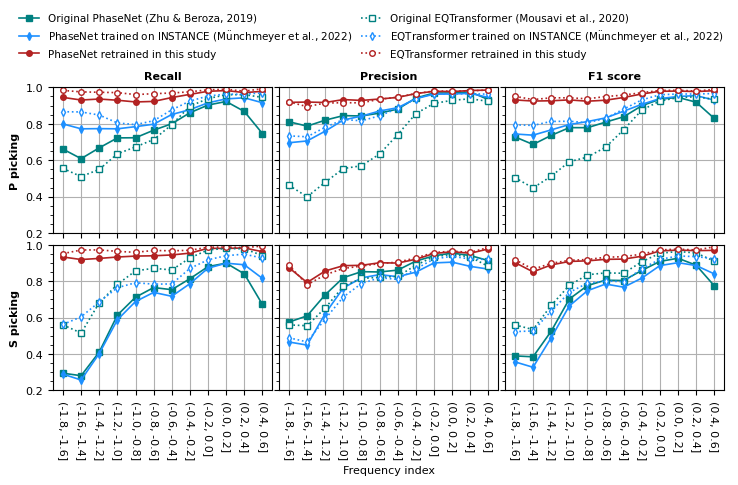

In [9]:
cm = 1 / 2.54
fig, axs = plt.subplots(2, 3, figsize=(22 * cm, 10 * cm), sharex="all", sharey="all")
plt.subplots_adjust(wspace=0.03, hspace=0.08)

labels = {
    "org_eqt": "Original EQTransformer (Mousavi et al., 2020)",
    "int_eqt": r"EQTransformer trained on INSTANCE (M$\rm{\"u}$nchmeyer et al., 2022)",
    "vol_eqt": "EQTransformer retrained in this study",
    "org_pn": "Original PhaseNet (Zhu & Beroza, 2019)",
    "int_pn": r"PhaseNet trained on INSTANCE (M$\rm{\"u}$nchmeyer et al., 2022)",
    "vol_pn": "PhaseNet retrained in this study",
}
lw = 1.2
ms = 4.0
fts = 8

markerfacecolors = [None, "white"]
markeredgecolors = [None, None]
markers = ["s", "d", "o"]
linestyles = ["solid", "dotted"]
colors = ["teal", "dodgerblue", "firebrick"]
for i_net, pred_dirs in enumerate([pn_pred_dirs, eqt_pred_dirs]):
    markerfacecolor = markerfacecolors[i_net]
    markeredgecolor = markeredgecolors[i_net]
    linestyle = linestyles[i_net]

    for i in range(3):
        exp_name = pred_dirs[i]
        color = colors[i]
        marker = markers[i]

        for j, phase in enumerate(["p", "s"]):
            metrics_vs_fi = pd.read_csv(
                root_save_path / f"{phase}.{save_csv_names[exp_name]}"
            )
            metrics_vs_fi = metrics_vs_fi[metrics_vs_fi["n_seis"] > nseis_lower_limit]
            for k, metric in enumerate(["recall", "precision", "F1score"]):
                FIs = metrics_vs_fi["FI"].values
                intervals = (
                    metrics_vs_fi["FI_interval"]
                    .apply(lambda x: x.replace(",", ", "))
                    .values
                )
                ax = axs[j][k]
                metric_value = metrics_vs_fi[f"{phase}_{metric}"]
                ax.plot(
                    FIs,
                    metric_value,
                    color=color,
                    linewidth=lw,
                    linestyle=linestyle,
                    marker=marker,
                    markeredgecolor=markeredgecolor,
                    markerfacecolor=markerfacecolor,
                    markersize=ms,
                    label=labels[exp_name],
                )
                ax.tick_params(labelsize=fts)
                ax.set_xticks(FIs)
                ax.set_xticklabels(intervals, rotation=-90)  # , ha="left"
                ax.yaxis.set_minor_locator(MultipleLocator(0.05))
                ax.set_ylim([0.2, 1])
                ax.grid(True)
axs[0][0].set_ylabel("P picking", fontsize=fts, weight="bold")
axs[1][0].set_ylabel("S picking", fontsize=fts, weight="bold")
axs[0][0].set_title("Recall", fontsize=fts, weight="bold")
axs[0][1].set_title("Precision", fontsize=fts, weight="bold")
axs[0][2].set_title("F1 score", fontsize=fts, weight="bold")
axs[0][0].legend(
    loc="lower left",
    bbox_to_anchor=(-0.2, 1.13, 1, 0.5),
    frameon=False,
    fontsize=fts - 0.5,
    ncols=2,
    columnspacing=0.9,
)
axs[1][1].set_xlabel("Frequency index", fontsize=fts)

# for i,ax in enumerate(axs.flat):
#     ax.text(
#             0.02,
#             0.98,
#             "("+chr(97+i)+")",
#             verticalalignment="top",
#             horizontalalignment="left",
#             transform=ax.transAxes,
#             fontsize=fts,
#             weight="bold",
#             color="black",
#         )
plt.savefig(
    root_save_path / f"alt_metrics_vs_fi.pdf",
    dpi=600,
    bbox_inches="tight",
    pad_inches=0,
)

In [10]:
save_csv_names

{'org_pn': 'org_pn_fi.csv',
 'int_pn': 'int_pn_fi.csv',
 'vol_pn': 'vol_pn_fi.csv',
 'org_eqt': 'org_eqt_fi.csv',
 'vol_eqt': 'vol_eqt_fi.csv',
 'int_eqt': 'int_eqt_fi.csv'}

In [32]:
metrics_vs_fi = pd.read_csv(root_save_path / f"p.org_pn_fi.csv")
metrics_vs_fi = metrics_vs_fi[metrics_vs_fi["n_seis"] > nseis_lower_limit]

In [28]:
metrics_vs_fi["s_F1score"]

,prob_thre,s_TP,s_FP,s_FN,s_precision,s_recall,s_F1score,s_mean,s_median,s_std,...,s_modified_MAD,s_modified_mean2,s_modified_median2,s_modified_std2,s_modified_RMSE2,s_modified_MAE2,s_modified_MAD2,FI,FI_interval,n_seis
0,0.17,1.0,0.0,0.0,1.000000,1.000000,1.000000,-0.170000,-4.12,NaN,...,0.000,-0.170000,-0.170,NaN,0.170000,0.170000,0.000,-2.3,"(-2.4,-2.2]",1
1,0.17,0.0,5.0,11.0,0.000000,0.000000,NaN,0.950000,-0.94,4.350506,...,0.070,-0.636667,-0.640,0.065064,0.638879,0.636667,0.060,-2.1,"(-2.2,-2.0]",11
2,0.17,6.0,22.0,46.0,0.214286,0.115385,0.150000,-0.046786,-0.03,1.195953,...,0.530,-0.378667,-0.620,0.459967,0.583826,0.497333,0.250,-1.9,"(-2.0,-1.8]",52
3,0.17,51.0,80.0,201.0,0.389313,0.202381,0.266319,0.033182,-0.12,2.826289,...,0.675,-0.194805,-0.040,0.426478,0.466337,0.360779,0.280,-1.7,"(-1.8,-1.6]",255
4,0.17,144.0,213.0,554.0,0.403361,0.206304,0.272986,-0.025568,-0.12,3.468058,...,0.615,-0.171729,-0.060,0.433311,0.465157,0.353131,0.255,-1.5,"(-1.6,-1.4]",714
5,0.17,404.0,371.0,923.0,0.521290,0.304446,0.384396,-0.186567,-0.09,3.895239,...,0.450,-0.012783,0.030,0.409884,0.409703,0.293043,0.160,-1.3,"(-1.4,-1.2]",1367
6,0.17,1215.0,800.0,1448.0,0.602978,0.456252,0.519453,-0.110020,-0.04,4.531635,...,0.210,0.082468,0.080,0.305569,0.316395,0.217504,0.110,-1.1,"(-1.2,-1.0]",2771
7,0.17,2175.0,1256.0,1817.0,0.633926,0.544840,0.586016,-0.057001,0.00,5.086103,...,0.170,0.120183,0.090,0.273570,0.298754,0.204086,0.100,-0.9,"(-1.0,-0.8]",4162
8,0.17,2097.0,1223.0,1435.0,0.631627,0.593715,0.612084,-0.043513,0.02,5.331978,...,0.180,0.106772,0.080,0.257262,0.278487,0.190351,0.090,-0.7,"(-0.8,-0.6]",3698
9,0.17,1504.0,816.0,883.0,0.648276,0.630080,0.639048,-0.055937,0.03,5.510142,...,0.160,0.079176,0.060,0.252374,0.264429,0.174072,0.080,-0.5,"(-0.6,-0.4]",2540


In [34]:
np.max(metrics_vs_fi["p_F1score"])

0.8952929875120077

In [38]:
metrics_vs_fi = pd.read_csv(root_save_path / f"s.vol_pn_fi.csv")
metrics_vs_fi = metrics_vs_fi[metrics_vs_fi["n_seis"] > nseis_lower_limit]

In [39]:
np.min(metrics_vs_fi["s_F1score"])

0.7547169811320755

In [40]:
metrics_vs_fi["s_F1score"]

3     0.832000
4     0.754717
5     0.813212
6     0.847201
7     0.851530
8     0.864380
9     0.865340
10    0.893173
11    0.935659
12    0.945680
13    0.943662
14    0.954545
Name: s_F1score, dtype: float64

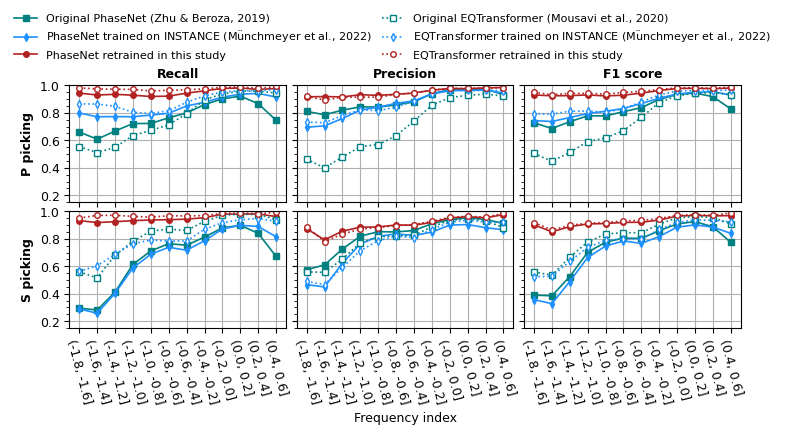

In [11]:
cm = 1 / 2.54
fig, axs = plt.subplots(2, 3, figsize=(22 * cm, 8 * cm), sharex="all", sharey="all")
plt.subplots_adjust(wspace=0.05, hspace=0.08)

labels = {
    "org_eqt": "Original EQTransformer (Mousavi et al., 2020)",
    "int_eqt": r"EQTransformer trained on INSTANCE (M$\rm{\"u}$nchmeyer et al., 2022)",
    "vol_eqt": "EQTransformer retrained in this study",
    "org_pn": "Original PhaseNet (Zhu & Beroza, 2019)",
    "int_pn": r"PhaseNet trained on INSTANCE (M$\rm{\"u}$nchmeyer et al., 2022)",
    "vol_pn": "PhaseNet retrained in this study",
}
lw = 1.2
ms = 4.0
fts = 9

markerfacecolors = [None, "white"]
markeredgecolors = [None, None]
markers = ["s", "d", "o"]
linestyles = ["solid", "dotted"]
colors = ["teal", "dodgerblue", "firebrick"]
for i_net, pred_dirs in enumerate([pn_pred_dirs, eqt_pred_dirs]):
    markerfacecolor = markerfacecolors[i_net]
    markeredgecolor = markeredgecolors[i_net]
    linestyle = linestyles[i_net]

    for i in range(3):
        exp_name = pred_dirs[i]
        color = colors[i]
        marker = markers[i]

        for j, phase in enumerate(["p", "s"]):
            metrics_vs_fi = pd.read_csv(
                root_save_path / f"{phase}.{save_csv_names[exp_name]}"
            )
            metrics_vs_fi = metrics_vs_fi[metrics_vs_fi["n_seis"] > nseis_lower_limit]
            for k, metric in enumerate(["recall", "precision", "F1score"]):
                FIs = metrics_vs_fi["FI"].values
                intervals = (
                    metrics_vs_fi["FI_interval"]
                    .apply(lambda x: x.replace(",", ", "))
                    .values
                )
                ax = axs[j][k]
                metric_value = metrics_vs_fi[f"{phase}_{metric}"]
                ax.plot(
                    FIs,
                    metric_value,
                    color=color,
                    linewidth=lw,
                    linestyle=linestyle,
                    marker=marker,
                    markeredgecolor=markeredgecolor,
                    markerfacecolor=markerfacecolor,
                    markersize=ms,
                    label=labels[exp_name],
                )
                ax.tick_params(labelsize=fts)
                ax.set_xticks(FIs)
                ax.set_xticklabels(intervals, rotation=-75)  # , ha="left"
                ax.yaxis.set_major_locator(MultipleLocator(0.2))
                ax.yaxis.set_minor_locator(MultipleLocator(0.05))
                ax.set_ylim([0.15, 1])
                ax.grid(True)
axs[0][0].set_ylabel("P picking", fontsize=fts, weight="bold")
axs[1][0].set_ylabel("S picking", fontsize=fts, weight="bold")
axs[0][0].set_title("Recall", fontsize=fts, weight="bold")
axs[0][1].set_title("Precision", fontsize=fts, weight="bold")
axs[0][2].set_title("F1 score", fontsize=fts, weight="bold")
axs[0][0].legend(
    loc="lower left",
    bbox_to_anchor=(-0.3, 1.13, 1, 0.5),
    frameon=False,
    fontsize=fts - 1.0,
    ncols=2,
    columnspacing=0.9,
)
axs[1][1].set_xlabel("Frequency index", fontsize=fts)

# for i,ax in enumerate(axs.flat):
#     ax.text(
#             0.02,
#             0.98,
#             "("+chr(97+i)+")",
#             verticalalignment="top",
#             horizontalalignment="left",
#             transform=ax.transAxes,
#             fontsize=fts,
#             weight="bold",
#             color="black",
#         )
plt.savefig(
    root_save_path / f"alt_metrics_vs_fi_smaller_size.pdf",
    dpi=600,
    bbox_inches="tight",
    pad_inches=0,
)